# Smart Optimization to Save Computing Time

In [ ]:
???

<table style="width:100%; height:90%">
      <tr>
    <th>Grid Search</th>
    <th>Smart Search</th>
  </tr>
  <tr>
    <td><img src="src/07_Table_Optimize BG Default Defaults.png" alt="Optimizing Limits' Parameters" style="width:100%"></td>
    <td><img src="src/08_Table_Smart Optimization.png" alt="Parametrize the Strategy" style="width:100%"></td>
  </tr>
</table>

## Load the model

In [8]:
import pickle

In [9]:
with open('models/model_dt_regression.pkl', 'rb') as f:
    model_dt = pickle.load(f)

/Users/sota/miniforge3/envs/backtesting/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
model_dt

DecisionTreeRegressor(max_depth=15)

## Load the data

In [11]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

,Open,High,Low,Close,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2016-12-08,56.325228,56.582507,55.902560,56.058762,21220800,1.549143,UP
2016-12-09,56.214968,56.959234,56.169027,56.940857,27349400,0.321692,UP
...,...,...,...,...,...,...,...
2023-03-14,256.750000,261.070007,255.860001,260.790009,33620300,1.751806,UP
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000,3.895731,UP


## Parametrize & optimize the investment strategy

### Create Strategy class

In [12]:
from backtesting import Strategy

In [13]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create `Backtest` class

In [14]:
from backtesting import Backtest

In [15]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [16]:
bt = Backtest(df_explanatory, SimpleRegression,
              cash=10000, commission=.002, exclusive_orders=True)

### Optimize backtesting with multiple combinations

In [9]:
import multiprocessing as mp
mp.set_start_method('fork')

In [10]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

CPU times: user 17.1 s, sys: 91 ms, total: 17.1 s
Wall time: 17.5 s


### Which are the best values for the parameters?

In [22]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')
dff

In [17]:
dff.style.highlight_null(props='background-color: transparent; color: transparent')

limit_sell,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,,,
0,nan,337.745113,nan,nan,nan,nan,nan,nan,nan,11721.523635,nan
1,nan,nan,nan,295.350207,nan,448.287855,nan,nan,nan,2529.445178,nan
2,nan,nan,nan,nan,215.076395,nan,440.224724,nan,390.127920,nan,-3.137514
3,nan,nan,204.955270,nan,nan,nan,nan,268.790120,nan,-45.846707,nan
4,191.296430,nan,nan,nan,nan,nan,nan,-72.062746,-74.879463,nan,nan
5,nan,nan,nan,nan,nan,87.385464,nan,nan,nan,-100.000000,-100.000000
6,nan,191.296430,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,nan,191.296430,nan,264.307150,nan,nan,nan,nan,nan,nan,-100.000000
8,nan,nan,nan,nan,70.012364,-23.386490,nan,-100.000000,nan,nan,nan


In [16]:
import numpy as np

In [18]:
dff.sort_index(axis=1, ascending=False)\
    .style.format(precision=0)\
    .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff))\
    .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,nan,11722,nan,nan,nan,nan,nan,nan,nan,338,nan
1,nan,2529,nan,nan,nan,448,nan,295,nan,nan,nan
2,-3,nan,390,nan,440,nan,215,nan,nan,nan,nan
3,nan,-46,nan,269,nan,nan,nan,nan,205,nan,nan
4,nan,nan,-75,-72,nan,nan,nan,nan,nan,nan,191
5,-100,-100,nan,nan,nan,87,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,191,nan
7,-100,nan,nan,nan,nan,nan,nan,264,nan,191,nan
8,nan,nan,nan,-100,nan,-23,70,nan,nan,nan,nan


### How to interpret smart optimization?

#### Number of evaluations

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

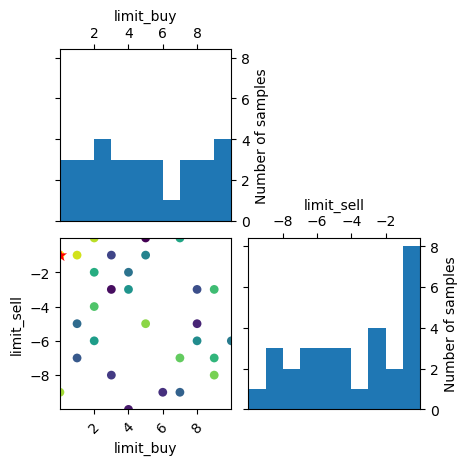

In [19]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

#### Density

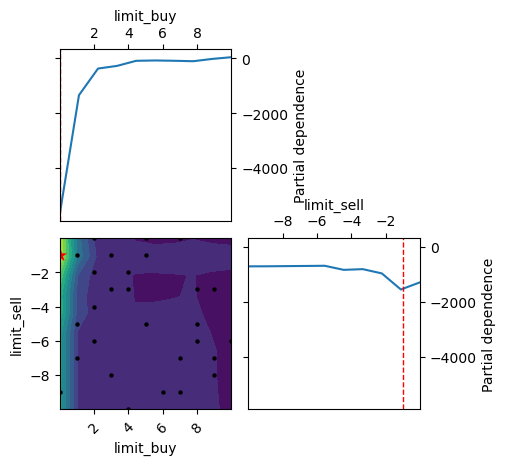

In [20]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="08D_Smart Optimization to Save Computing Time.ipynb">notebook</a>.